# Water Interoperability Similarity

## Background

There are a few water classifiers for Landsat, Sentinel-1, and Sentinel-2. We will examine WOfS for Landsat, thresholding for Sentinel-1, and WOfS for Sentinel-2.

Although WOfS performs well on clear water bodies, it can misclassify murky water bodies as not water. WASARD or Sentinel-1 thresholding generally perform equally well or better than WOfS – especially on murky water bodies.

Because WOfS uses an optical data source (Landsat), it often does not have data to make water classifications due to cloud occlusion. The same limitation applies to Sentinel-2 water detection.

The main reasons to use multiple data sources in the same water detection analysis are to increase temporal resolution and account for missing data.

## Description

This notebook checks how similar water classifications are among a selected set of sources (e.g. WOfS for Landsat, thresholding for Sentinel-1, etc.).
These are the steps followed:

1. Determine the dates of coincidence of data for the selected sensors using the CEOS COVE tool.
1. Acquire water classifications for each sensor.
1. Show the RGB representation of Time Slices and Water Classifications
1. Obtain the intersected clean mask for the sensors.
1. Show the per-time-slice percent of cloud according to each sensor as a line plot.
1. Show the per-time-slice percent of water (masked with the intersected clean mask) according to each sensor as a line plot.
1. Show the per-time-slice similarity (% of matching pixels) of each pair of sensors as a line plot.
***

## Getting started

**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import sys
import datacube
import numpy
import numpy as np
import xarray as xr
from xarray.ufuncs import isnan as xr_nan
import pandas as pd
import matplotlib.pyplot as plt

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="water_interoperability_similarity")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The parameters are

* `latitude`: The latitude range to analyse (e.g. `(-11.288, -11.086)`).
For reasonable loading times, make sure the range spans less than ~0.1 degrees.
* `longitude`: The longitude range to analyse (e.g. `(130.324, 130.453)`).
For reasonable loading times, make sure the range spans less than ~0.1 degrees.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers an area around Obuasi, Ghana.

**To run the notebook for a different area**, make sure Landsat 8, Sentinel-1, and Sentinel-2 data is available for the chosen area.

In [3]:
# Define the area of interest
# Obuasi, Ghana
# latitude = (6.10, 6.26)
# longitude = (-1.82, -1.66)
# latitude = (6.1582, 6.2028)
# longitude = (-1.7295, -1.6914)

# DEBUG - small area of Obuasi for quick loading
# latitude = (6.1982, 6.2028)
# longitude = (-1.7295, -1.6914)

# Tono Dam, Ghana
latitude = (10.8600, 10.9150) 
longitude = (-1.1850, -1.1425)

# The time range in which we want to determine 
# dates of close scenes among sensors.
time_extents = ('2014-01-01', '2018-12-31')

In [4]:
from utils.data_cube_utilities.dc_display_map import display_map

display_map(longitude, latitude)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## Determine the dates of coincidence of data for the selected sensors using the COVE tool.

We used a tool from the Committee on Earth Observations (CEOS) called the CEOS Visualization Environment (COVE). This tool has several applications, such as Acquisition Forecaster predicts when and where future acquisitions (images) will occur, and Coverage Analyzer which shows when and where acquisitions have occurred in the past.

For this analysis, we used the Coincident Calculator to determine when Landsat 8, Sentinel-1, and Sentinel-2 have close dates so we can compare them on a per-time-slice basis.

The [COVE Coincident Calculator](https://ceos-cove.org/en/coincident_calculator/) allows users to specify the sensors to determine coincidence for. For this analysis, we first determined the dates of coincidence of Landsat 8 and Sentinel-2. We then determined dates which are close to those which have Sentinel-1 data.

We first found dates for which both Landsat 8 and Sentinel-2 data is available for the time range and area of interest, which were the following 8 dates:
**\[April 22, 2017, July 11, 2017, September 29, 2017, December 18, 2017, March 8, 2018, May 27, 2018, August 15, 2018, November 3, 2018\]**

Then we found dates for which Landsat 8 and Sentinel-1 data is available for the time range and area of interest, and then found the subset of closely matching dates, which were the following 6 dates: **\[July 12, 2017 (off 1), September 29, 2017, December 15, 2017 (off 3), March 9, 2018 (off 1), May 27, 2018, August 12, 2018 (off 3)\]** These are the daets we use in this analysis.

## Acquire water classifications for each sensor.

In [5]:
common_load_params = dict(latitude=latitude, longitude=longitude, 
                          group_by='solar_day', 
                          output_crs="epsg:4326",
                          resolution=(-0.00027,0.00027))

# The minimum percent of data that a time slice must have
# to be kept in this analysis
MIN_PCT_DATA = 0

### Determine the time range of overlapping data for all sensors.

In [6]:
metadata = {}

In [7]:
metadata['Landsat 8'] = dc.load(**common_load_params,
                                product='ls8_usgs_sr_scene', 
                                time=time_extents, 
                                dask_chunks={'time':1})

In [8]:
metadata['Sentinel-1'] = dc.load(**common_load_params,
                                 product='sentinel1_ghana_monthly', 
                                 time=time_extents, 
                                 dask_chunks={'time':1})

In [9]:
s2a_meta = dc.load(**common_load_params,
                   product='s2a_msil2a', 
                   time=time_extents, 
                   dask_chunks={'time':1})
s2b_meta = dc.load(**common_load_params,
                   product='s2b_msil2a', 
                   time=time_extents, 
                   dask_chunks={'time':1})
metadata['Sentinel-2'] = xr.concat((s2a_meta, s2b_meta), dim='time').sortby('time')
del s2a_meta, s2b_meta

In [10]:
ls8_time_rng = metadata['Landsat 8'].time.values[[0,-1]]
s2_time_rng = metadata['Sentinel-2'].time.values[[0,-1]]

time_rng = np.stack((ls8_time_rng, s2_time_rng))
overlapping_time = time_rng[:,0].max(), time_rng[:,1].min()

**Limit the metadata to check for close scenes to the overlapping time range.**

In [11]:
for sensor in metadata:
    metadata[sensor] = metadata[sensor].sel(time=slice(*overlapping_time))

### Determine the dates of close scenes among the sensors

In [12]:
# Constants #
# The maximum number of days of difference between scenes
# from sensors for those scenes to be considered approximately coincident.
# The Sentinel-1 max date diff is set high enough to allow any set of dates 
# from the other sensors to match with one of its dates since we will 
# select its matching dates with special logic later.
MAX_NUM_DAYS_DIFF = {'Landsat 8':4, 'Sentinel-1':30, 'Sentinel-2':4}
# End Constants #

# all_times
num_datasets = len(metadata)
ds_names = list(metadata.keys())
first_ds_name = ds_names[0]
# All times for each dataset.
ds_times = {ds_name: metadata[ds_name].time.values for ds_name in ds_names}
# The time indices for each dataset's sorted time dimension 
# currently being compared.
time_inds = {ds_name: 0 for ds_name in ds_names}
corresponding_times = {ds_name: [] for ds_name in ds_names}

# The index of the dataset in `metadata` to compare times against the first.
oth_ds_ind = 1
oth_ds_name = ds_names[oth_ds_ind]
oth_ds_time_ind = time_inds[oth_ds_name]
# For each time in the first dataset, find any 
# closely matching dates in the other datasets.
for first_ds_time_ind, first_ds_time in enumerate(ds_times[first_ds_name]):
    time_inds[first_ds_name] = first_ds_time_ind
    # Find a corresponding time in this other dataset.
    while True:
        oth_ds_name = ds_names[oth_ds_ind]
        oth_ds_time_ind = time_inds[oth_ds_name]
        # If we've checked all dates for the other dataset, 
        # check the next first dataset time.
        if oth_ds_time_ind == len(ds_times[oth_ds_name]):
            break
        oth_ds_time = metadata[ds_names[oth_ds_ind]].time.values[oth_ds_time_ind]
        time_diff = (oth_ds_time - first_ds_time).astype('timedelta64[D]').astype(int)
        
        # If this other dataset time is too long before this
        # first dataset time, check the next other dataset time.
        if time_diff <= -MAX_NUM_DAYS_DIFF[oth_ds_name]:
            oth_ds_time_ind += 1
            time_inds[ds_names[oth_ds_ind]] = oth_ds_time_ind
            continue
        # If this other dataset time is within the acceptable range
        # of the first dataset time...
        elif abs(time_diff) <= MAX_NUM_DAYS_DIFF[oth_ds_name]:
            # If there are more datasets to find a corresponding date for
            # these current corresponding dates, check those datasets.
            if oth_ds_ind < len(ds_names)-1:
                oth_ds_ind += 1
                continue
            else: # Otherwise, record this set of corresponding dates.
                for ds_name in ds_names:
                    corresponding_times[ds_name].append(ds_times[ds_name][time_inds[ds_name]])
                    # Don't use these times again.
                    time_inds[ds_name] = time_inds[ds_name] + 1
                oth_ds_ind = 1
                break
        # If this other dataset time is too long after this
        # first dataset time, go to the next first dataset time.
        else:
            oth_ds_ind -= 1
            break


In [13]:
# convert to pandas datetime
for sensor in corresponding_times:
    for ind in range(len(corresponding_times[sensor])):
        corresponding_times[sensor][ind] = \
            pd.to_datetime(corresponding_times[sensor][ind])

**The Sentinel-1 data is a monthly composite, so we need special logic for choosing data from it.**

In [14]:
ls8_pd_datetimes = corresponding_times['Landsat 8'] 
s1_pd_datetimes = pd.to_datetime(metadata['Sentinel-1'].time.values)
for time_ind, ls8_time in enumerate(ls8_pd_datetimes):
    matching_s1_time_ind = [s1_time_ind for (s1_time_ind, s1_time) 
                            in enumerate(s1_pd_datetimes) if 
                            s1_time.month == ls8_time.month][0]
    matching_s1_time = metadata['Sentinel-1'].time.values[matching_s1_time_ind]
    corresponding_times['Sentinel-1'][time_ind] = pd.to_datetime(matching_s1_time)

### Landsat 8

**Load the data**

In [15]:
ls8_times = corresponding_times['Landsat 8']
s1_times = corresponding_times['Sentinel-1']
s2_times = corresponding_times['Sentinel-2']

In [16]:
ls8_data = []
ls8_data = dc.load(**common_load_params,
                   product='ls8_usgs_sr_scene', 
                   time=(ls8_times[0], ls8_times[-1]),
                   dask_chunks = {'time': 1})
ls8_data = ls8_data.sel(time=corresponding_times['Landsat 8'], method='nearest')
print(f"Subset the data to {len(ls8_data.time)} times of near coincidence.")

Subset the data to 10 times of near coincidence.


**Acquire the clean mask**

In [17]:
from water_interoperability_utils.clean_mask import ls8_unpack_qa

In [18]:
ls8_data_mask = (ls8_data != -9999).to_array().any('variable')
ls8_clear_mask = ls8_unpack_qa(ls8_data.pixel_qa, 'clear')
ls8_water_mask = ls8_unpack_qa(ls8_data.pixel_qa, 'water')
ls8_clean_mask = (ls8_clear_mask | ls8_water_mask) & ls8_data_mask 
del ls8_clear_mask, ls8_water_mask

**Acquire water classifications**

In [19]:
from water_interoperability_utils.dc_water_classifier import wofs_classify
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=Warning)
    ls8_water = wofs_classify(ls8_data).wofs
ls8_water = ls8_water.where(ls8_clean_mask)

### Sentinel-1

**Load the data**

In [20]:
s1_data = dc.load(**common_load_params,
                  product='sentinel1_ghana_monthly', 
                  time=(s1_times[0], s1_times[-1]),
                  dask_chunks = {'time': 1})
s1_data = s1_data.sel(time=corresponding_times['Sentinel-1'], method='nearest')
print(f"Subset the data to {len(s1_data.time)} times of near coincidence.")

Subset the data to 10 times of near coincidence.


**Acquire the clean mask**

In [21]:
s1_not_nan_da = ~xr_nan(s1_data).to_array()
s1_clean_mask = s1_not_nan_da.min('variable')
del s1_not_nan_da

**Acquire water classifications**

In [22]:
from sklearn.impute import SimpleImputer
from skimage.filters import try_all_threshold, threshold_otsu

thresh_vv = threshold_otsu(s1_data.vv.values)
thresh_vh = threshold_otsu(s1_data.vh.values)

binary_vv = s1_data.vv.values < thresh_vv
binary_vh = s1_data.vh.values < thresh_vh

s1_water = xr.DataArray(binary_vv & binary_vh, coords=s1_data.vv.coords, 
                        dims=s1_data.vv.dims, attrs=s1_data.vv.attrs)
s1_water = s1_water.where(s1_clean_mask)

### Sentinel-2

**Acquire the data**

In [23]:
s2a_data = dc.load(**common_load_params,
                   product='s2a_msil2a', 
                   time=(s2_times[0], s2_times[-1]),
                   dask_chunks = {'time': 1})
s2b_data = dc.load(**common_load_params,
                   product='s2b_msil2a', 
                   time=(s2_times[0], s2_times[-1]),
                   dask_chunks = {'time': 1})
s2_data = xr.concat((s2a_data, s2b_data), dim='time').sortby('time')
s2_data = s2_data.sel(time=corresponding_times['Sentinel-2'], method='nearest')
print(f"Subsetting the data to {len(s2_data.time)} times of near coincidence.")

Subsetting the data to 10 times of near coincidence.


**Acquire the clean mask**

In [24]:
# See figure 3 on this page for more information about the
# values of the scl data for Sentinel-2: 
# https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
s2_clean_mask = s2_data.scl.isin([1, 2, 3, 4, 5, 6, 7, 10, 11]) 

**Acquire water classifications**

In [25]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=Warning)
    s2_water = wofs_classify(s2_data.rename(
        {'nir_1': 'nir', 'swir_1': 'swir1', 'swir_2': 'swir2'})).wofs
s2_water = s2_water.where(s2_clean_mask)

In [26]:
ls8_data = ls8_data.compute()
ls8_clean_mask = ls8_clean_mask.compute()

s1_data = s1_data.compute()
s1_clean_mask = s1_clean_mask.compute()

s2_data = s2_data.compute()
s2_clean_mask = s2_clean_mask.compute()

## Show the RGB Representation of Time Slices and Water Classifications

**Obtain the intersected clean mask for the sensors.**

In [27]:
intersected_clean_mask = xr.DataArray((ls8_clean_mask.values & 
                                       s1_clean_mask.values & 
                                       s2_clean_mask.values), 
                                       coords=ls8_clean_mask.coords, 
                                       dims=ls8_clean_mask.dims)

In [28]:
# Mask the water classes.
ls8_water = ls8_water.where(intersected_clean_mask.values)
s1_water = s1_water.where(intersected_clean_mask.values)
s2_water = s2_water.where(intersected_clean_mask.values)

In [29]:
# Remove any times with no data for any sensor.
times_to_keep_mask = (intersected_clean_mask.sum(['latitude', 'longitude']) / \
    intersected_clean_mask.count(['latitude', 'longitude'])) > MIN_PCT_DATA
# The time indices to keep for visualization.
time_inds_subset = np.arange(len(ls8_data.time))[times_to_keep_mask.values]

In [30]:
intersected_clean_mask_subset = \
    intersected_clean_mask.isel(time=time_inds_subset)

ls8_data_subset = ls8_data.isel(time=time_inds_subset)
ls8_clean_mask_subset = ls8_clean_mask.isel(time=time_inds_subset)
ls8_water_subset = ls8_water.isel(time=time_inds_subset)

s1_data_subset = s1_data.isel(time=time_inds_subset)
s1_clean_mask_subset = s1_clean_mask.isel(time=time_inds_subset)
s1_water_subset = s1_water.isel(time=time_inds_subset)

s2_data_subset = s2_data.isel(time=time_inds_subset)
s2_clean_mask_subset = s2_clean_mask.isel(time=time_inds_subset)
s2_water_subset = s2_water.isel(time=time_inds_subset)

**Show the data and water classifications for each sensor as the data will be compared among them (an intersection).**

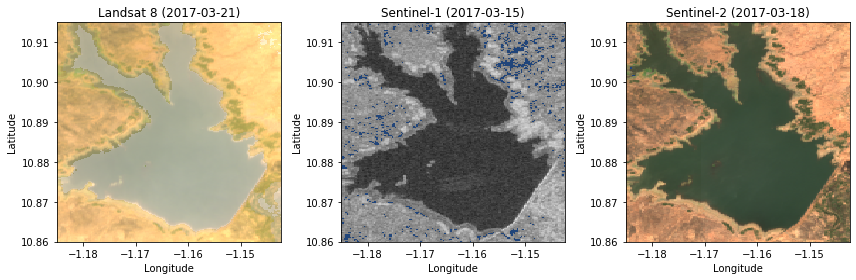

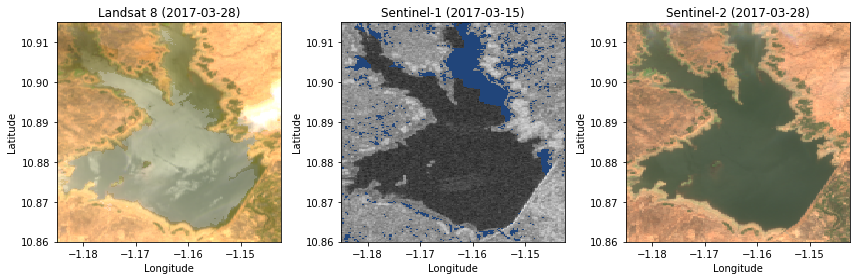

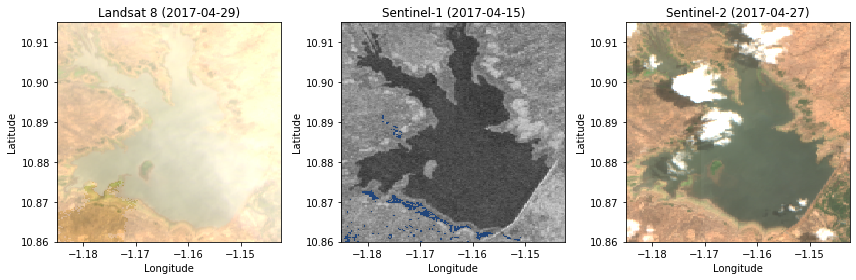

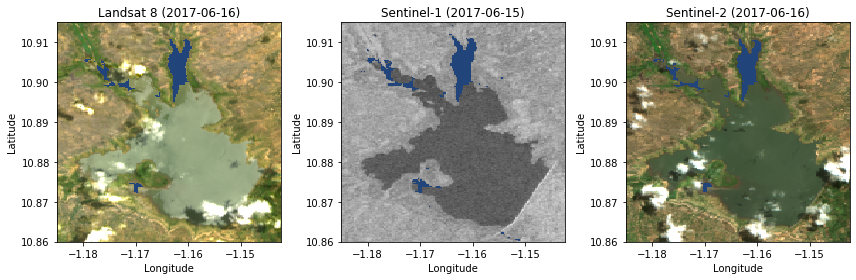

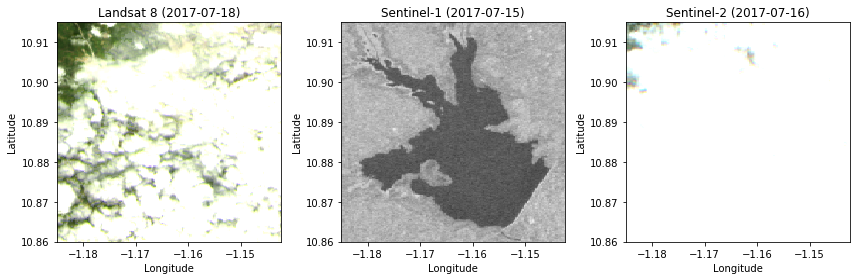

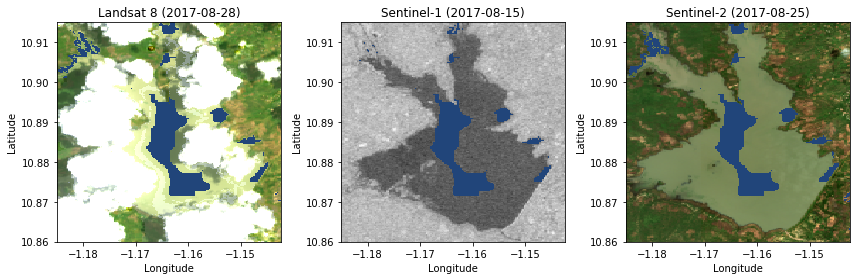

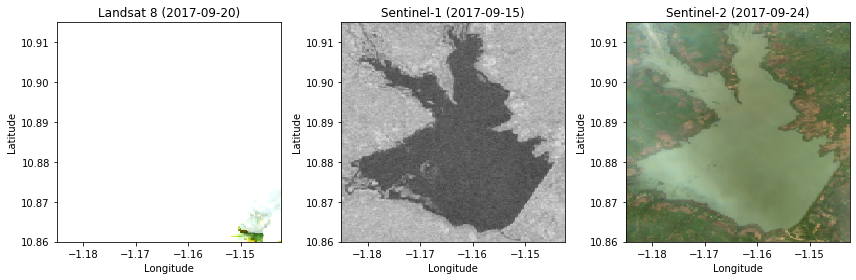

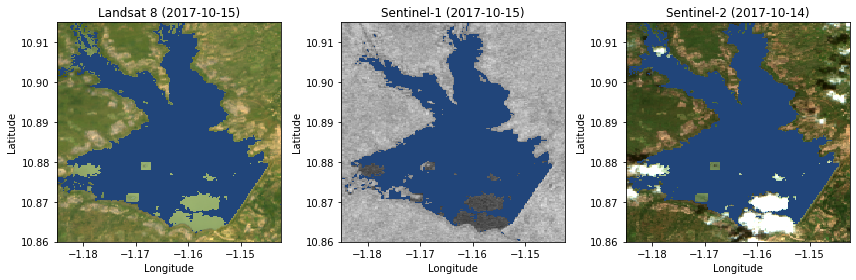

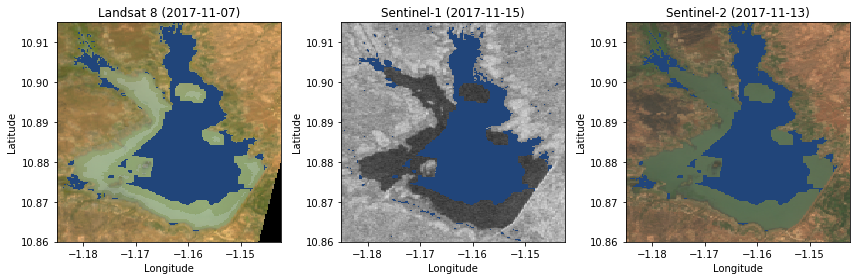

In [31]:
water_alpha = 0.9

for time_ind in range(len(ls8_data_subset.time)):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    # Mask out the water from the RGB so that its background segment is white instead of the RGB.
    ls8_data_subset.where(ls8_water_subset != 1)[['red', 'green', 'blue']].isel(time=time_ind).to_array().plot.imshow(ax=ax[0], vmin=0, vmax=1750)
    ls8_only_water = ls8_water_subset.where(ls8_water_subset == 1)
    ls8_only_water.isel(time=time_ind).plot.imshow(ax=ax[0], cmap='Blues', alpha=water_alpha, 
                                                   vmin=0, vmax=1, add_colorbar=False)
    ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Latitude')
    ax[0].set_title(f"Landsat 8 " \
                    f"({numpy.datetime_as_string(ls8_data_subset.time.values[time_ind], unit='D')})")
    
    s1_data_subset.where(s1_water_subset != 1).vv.isel(time=time_ind).plot.imshow(ax=ax[1], cmap='gray', vmin=-30, vmax=-0, add_colorbar=False)
    s1_only_water = s1_water_subset.where(s1_water_subset == 1)
    s1_only_water.isel(time=time_ind).plot.imshow(ax=ax[1], cmap='Blues', alpha=water_alpha, 
                                                  vmin=0, vmax=1, add_colorbar=False)
    ax[1].set_xlabel('Longitude')
    ax[1].set_ylabel('Latitude')
    ax[1].set_title(f"Sentinel-1 " \
                    f"({numpy.datetime_as_string(s1_data_subset.time.values[time_ind], unit='D')})")
    
    s2_data_subset.where(s2_water_subset != 1)[['red', 'green', 'blue']].isel(time=time_ind).to_array().plot.imshow(ax=ax[2], vmin=0, vmax=2500)
    s2_only_water = s2_water_subset.where(s2_water_subset == 1)
    s2_only_water.isel(time=time_ind).plot.imshow(ax=ax[2], cmap='Blues', alpha=water_alpha, 
                                                  vmin=0, vmax=1, add_colorbar=False)
    ax[2].set_xlabel('Longitude')
    ax[2].set_ylabel('Latitude')
    ax[2].set_title(f"Sentinel-2 " \
                    f"({numpy.datetime_as_string(s2_data_subset.time.values[time_ind], unit='D')})")
    
    plt.tight_layout()
    plt.show()

## Show the per-time-slice percent of water according to each sensor as a line plot.

In [32]:
ls8_water_subset_pct = \
    ls8_water_subset.sum(['latitude', 'longitude']) / \
    ls8_water_subset.count(['latitude', 'longitude']).compute()

s1_water_subset_pct = \
    s1_water_subset.sum(['latitude', 'longitude']) / \
    s1_water_subset.count(['latitude', 'longitude']).compute()
s1_water_subset_pct.time.values = ls8_water_subset_pct.time.values

s2_water_subset_pct = \
    s2_water_subset.sum(['latitude', 'longitude']) / \
    s2_water_subset.count(['latitude', 'longitude']).compute()
s2_water_subset_pct.time.values = ls8_water_subset_pct.time.values

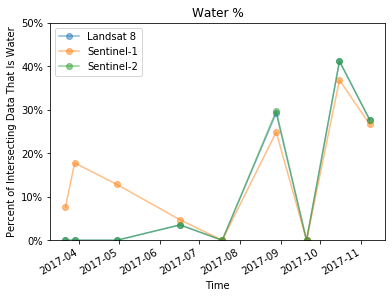

In [33]:
import matplotlib.ticker as mtick

ax = plt.gca()

plot_format = dict(ms=6, marker='o', alpha=0.5)

(ls8_water_subset_pct*100).plot(ax=ax, **plot_format, label='Landsat 8')
(s1_water_subset_pct*100).plot(ax=ax, **plot_format, label='Sentinel-1')
(s2_water_subset_pct*100).plot(ax=ax, **plot_format, label='Sentinel-2')

plt.ylim(0,50)

ax.set_xlabel('Time')
ax.set_ylabel('Percent of Intersecting Data That Is Water')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend()
plt.title('Water %')
plt.show()

## Show the per-time-slice similarity (% of matching pixels) of each pair of sensors as a line plot.

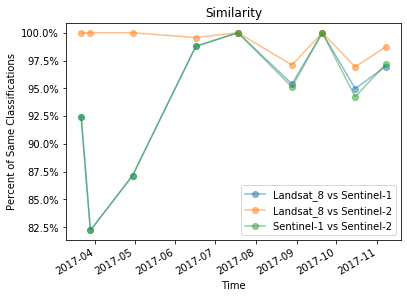

In [34]:
from itertools import combinations

ax = plt.gca()

water_das = [('Landsat_8', ls8_water_subset), 
             ('Sentinel-1', s1_water_subset), 
             ('Sentinel-2', s2_water_subset)]
for i, ((sensor_1, water_1), (sensor_2, water_2)) in enumerate(combinations(water_das, 2)):
    lat_dim_ind = np.argmax(np.array(water_1.dims) == 'latitude')
    lon_dim_ind = np.argmax(np.array(water_1.dims) == 'longitude')
    
    similarity = (water_1.values == water_2.values).sum(axis=(lat_dim_ind, lon_dim_ind)) / \
        intersected_clean_mask_subset.sum(['latitude', 'longitude'])
    (similarity*100).plot.line(ax=ax, **plot_format, label=f'{sensor_1} vs {sensor_2}')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Percent of Same Classifications')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.legend()
    plt.title('Similarity')
plt.show()